---
# Tutorial Objectives

*Estimated timing of tutorial: 1 hour, 15 minutes*

This is part 1 of a 2-part series about Generalized Linear Models (GLMs), which are a fundamental framework for supervised learning.

In this tutorial, the objective is to model a retinal ganglion cell spike train by fitting a temporal receptive field. First with a Linear-Gaussian GLM (also known as ordinary least-squares regression model) and then with a Poisson GLM (aka "Linear-Nonlinear-Poisson" model). In the next tutorial, we'll extend to a special case of GLMs, logistic regression, and learn how to ensure good model performance.
# Tutorial 1: GLMs for Encoding

**Week 1, Day 3: Generalized Linear Models**

**By Neuromatch Academy**

**Content creators:** Pierre-Etienne H. Fiquet, Ari Benjamin, Jakob Macke

**Content reviewers:** Davide Valeriani, Alish Dipani, Michael Waskom, Ella Batty

**Production editors:** Spiros Chavlis
This tutorial is designed to run with retinal ganglion cell spike train data from [Uzzell & Chichilnisky 2004](https://journals.physiology.org/doi/full/10.1152/jn.01171.2003?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed).

*Acknowledgements:*

- We thank EJ Chichilnisky for providing the dataset. Please note that it is provided for tutorial purposes only, and should not be distributed or used for publication without express permission from the author (ej@stanford.edu).
- We thank Jonathan Pillow, much of this tutorial is inspired by exercises assigned in his 'Statistical Modeling and Analysis of Neural Data' class.

If you want to download the slides: https://osf.io/download/upyjz/

---
# Setup

In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/reactiveBayes/RxInferPractice/juliaTutorials`


In [2]:
using RxInfer, Random, Plots, StableRNGs, LinearAlgebra, StatsPlots, LaTeXStrings, DataFrames, CSV, GLM, ColorSchemes, Statistics

In [3]:
function plot_stim_and_spikes(stim, spikes, dt, nt=120)
    #=
    Show time series of stim intensity and spike counts.

    Args:
        stim (Vector): vector of stimulus intensities
        spikes (Vector): vector of spike counts
        dt (Number): duration of each time step
        nt (Number): number of time steps to plot
    =#
    timepoints = 0:nt-1
    time = timepoints * dt

    plt = plot(layout=(2, 1), size=(800, 500), xlabel="Time (s)", sharex=true)

    plot!(plt[1, 1], time, stim[timepoints .+ 1], ylabel="Stimulus intensity")
    plot!(plt[2, 1], time, spikes[timepoints .+ 1], ylabel="Number of spikes")

    display(plt)
end


function plot_glm_matrices(X::Matrix, y::Vector, nt::Int=50)
    """
    Show X and Y as heatmaps.
    Args:
    X (2D array): Design matrix.
    y (1D array): Target vector.
    """
    
    Y = reshape(y, :, 1)  # Ensure Y is 2D and skinny
    println(Y)

    # Create a custom colormap for X
    custom_cmap = cgrad([:blue, :white, :red], [0, 0.5, 1])

    # Create the X plot with discrete colors
    p1 = heatmap(X[1:nt, :], 
        c=custom_cmap, clims=(-0.48, 0.48), 
        title="X\n(lagged stimulus)",
        xlabel="Time lag (time bins)",
        ylabel="Time point (time bins)",
        xticks=([4, 14, 24], ["-20", "-10", "0"]),
        yflip=true,
        colorbar_title="Stimulus value",
        size=(600, 800))

    # Create the Y plot with increased width
    p2 = heatmap(Y[1:nt, :], 
        c=:magma, clims=(0, maximum(y)), 
        title="Y\n(spike count)",
        xticks=nothing,
        colorbar_title="Spike count",
        yticks=nothing,
        yflip=true,
        size=(200, 800))

    # Combine the plots
    plot(p1, p2, layout=(1, 2), size=(800, 800), link=:y)
end

function plot_spike_filter(theta::Vector{<:Real}, dt::Real; show::Bool=true, kwargs...)
    """
    Plot estimated weights based on time lag model.
    Args:
    theta: Filter weights, not including DC term.
    dt: Duration of each time bin.
    show: Whether to display the plot.
    kwargs...: Additional keyword arguments to pass to plot()
    """
    d = length(theta)
    t = range(-d + 1, 0, length=d) .* dt
    
    p = plot(t, theta, marker=:circle, legend=false; kwargs...)
    hline!([0], color=:gray, linestyle=:dash)
    
    xlabel!("Time before spike (s)")
    ylabel!("Filter weight")
    
    if show
        display(p)
    end
end

function plot_spikes_with_prediction(spikes::Vector{T}, predicted_spikes::Vector{T}, dt::Real;
    nt::Int=50, t0::Int=120, show::Bool=true, kwargs...) where T <: Real
    """
    Plot actual and predicted spike counts.
    Args:
    spikes: Vector of actual spike counts
    predicted_spikes: Vector of predicted spike counts
    dt: Duration of each time bin.
    nt: Number of time bins to plot.
    t0: Index of first time bin to plot.
    show: Whether to display the plot.
    kwargs...: Additional keyword arguments to pass to plot()
    """
    t = (t0:t0+nt-1) .* dt

    # Create the main plot
    p = plot(size=(800, 600), legend=:topright)

    # Plot actual spikes as stem-like plot
    for (ti, si) in zip(t, spikes[1:nt])
        plot!([ti, ti], [0, si], color=:gray, label=(ti == t[1] ? "Spikes" : ""))
        scatter!([ti], [si], color=:gray, markersize=4, label="")
    end

    # Set default linewidth if not provided
    if !haskey(kwargs, :linewidth)
        kwargs = Dict(kwargs..., :linewidth => 3)
    end

    # Plot predicted spikes as a line
    plot!(t, predicted_spikes[1:nt], label="Predicted", color=:dodgerblue; kwargs...)

    xlabel!("Time (s)")
    ylabel!("Spikes")

    # Set y-axis to show only integer values
    ymax = max(maximum(spikes[1:nt]), maximum(predicted_spikes[1:nt]))
    yticks!(0:ceil(Int, ymax))

    return p
end

plot_spikes_with_prediction (generic function with 1 method)

In [4]:
using HTTP, Sockets, Dates, Logging

fname = "RGCdata.mat"
url = "https://osf.io/mzujs/download"
expected_md5 = "1b2977453020bce5319f2608c94d38d0"

response

if !isfile(fname)
    try
        response = HTTP.get(url)
        
        print(response.status)
        if response.status != Int16(200)
            @error "!!! Status was not 200 !!!"
        else
            open(fname, "w") do fid
                write(fid, response.body)
            end
        end

    catch e
        @error "!!! Failed to download data !!!" exception=e
    end
end

## Section 1.1: Load retinal ganglion cell activity data

*Estimated timing to here from start of tutorial: 10 min*

In this exercise we use data from an experiment that presented a screen which randomly alternated between two luminance values and recorded responses from retinal ganglion cell (RGC), a type of neuron in the retina in the back of the eye. This kind of visual stimulus is called a "full-field flicker", and it was presented at ~120Hz (ie. the stimulus presented on the screen was refreshed about every 8ms). These same time bins were used to count the number of spikes emitted by each neuron.

The file `RGCdata.mat` contains three variables:

- `Stim`, the stimulus intensity at each time point. It is an array with shape $T \times 1$, where $T=144051$.

-  `SpCounts`, the binned spike counts for 2 ON cells, and 2 OFF cells. It is a $144051 \times 4$ array, and each column has counts for a different cell.

- `dtStim`, the size of a single time bin (in seconds), which is needed for computing model output in units of spikes / s. The stimulus frame rate is given by `1 / dtStim`.

Because these data were saved in MATLAB, where everything is a matrix, we will also process the variables to more Pythonic representations (1D arrays or scalars, where appropriate) as we load the data.

In [5]:
function squeeze( A :: AbstractArray )
    keepdims = Tuple(i for i in size(A) if i != 1);
    return reshape( A, keepdims );
  end;

In [6]:
using MAT  # for loading .mat files

data = matread("RGCdata.mat")
dt_stim = data["dtStim"]  # No need for .item() in Julia

# Extract the stimulus intensity
stim = squeeze(data["Stim"])  # squeeze removes singleton dimensions

# Extract the spike counts for one cell
cellnum = 3
spikes = data["SpCounts"][:, cellnum]

# Don't use all of the timepoints in the dataset, for speed
keep_timepoints = 20000
stim = stim[1:keep_timepoints]
spikes = spikes[1:keep_timepoints]


20000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 2.0
 1.0
 0.0
 0.0
 ⋮
 3.0
 1.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0

Use the `plot_stim_and_spikes` helper function to visualize the changes in stimulus intensities and spike counts over time.

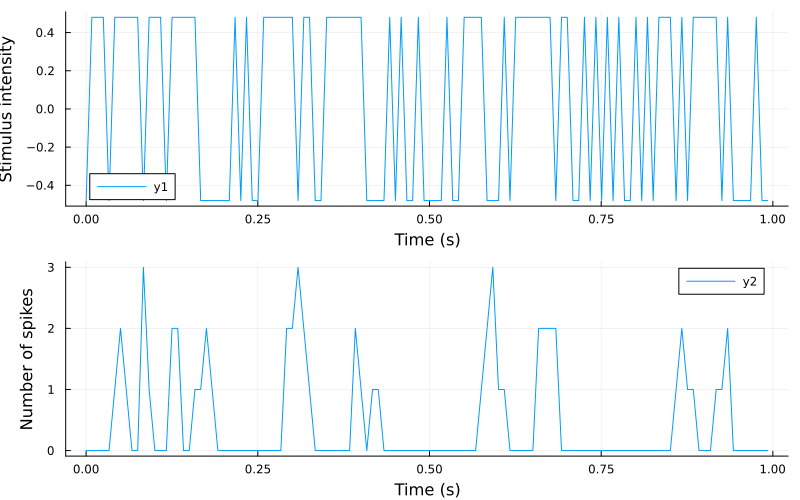

In [7]:
plot_stim_and_spikes(stim, spikes, dt_stim)

### Coding Exercise 1.1: Create design matrix

Our goal is to predict the cell's activity from the stimulus intensities preceding it. That will help us understand how RGCs process information over time. To do so, we first need to create the *design matrix* for this model, which organizes the stimulus intensities in matrix form such that the $i$th row has the stimulus frames preceding timepoint $i$.

In this exercise, we will create the design matrix $\mathbf{X}$ using $d=25$ time lags. That is, $\mathbf{X}$ should be a $T \times d$ matrix. $d = 25$ (about 200 ms) is a choice we're making based on our prior knowledge of the temporal window that influences RGC responses. In practice, you might not know the right duration to use.

The last entry in row `t` should correspond to the stimulus that was shown at time `t`, the entry to the left of it should contain the value that was shown one time bin earlier, etc. Specifically, $X_{ij}$ will be the stimulus intensity at time $i + d - 1 - j$.

Note that for the first few time bins, we have access to the recorded spike counts but not to the stimulus shown in the recent past. For simplicity we are going to assume that values of `stim` are 0 for the time lags prior to the first timepoint in the dataset. This is known as "zero-padding", so that the design matrix has the same number of rows as the response vectors in `spikes`.

Your task is is to complete the function below to:

  - make a zero-padded version of the stimulus
  - initialize an empty design matrix with the correct shape
  - **fill in each row of the design matrix, using the zero-padded version of the stimulus**

To visualize your design matrix (and the corresponding vector of spike counts), we will plot a "heatmap", which encodes the numerical value in each position of the matrix as a color. The helper functions include some code to do this.

[0.0; 0.0; 0.0; 0.0; 0.0; 1.0; 2.0; 1.0; 0.0; 0.0; 3.0; 1.0; 0.0; 0.0; 0.0; 2.0; 2.0; 0.0; 0.0; 1.0; 1.0; 2.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 2.0; 2.0; 3.0; 2.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 2.0; 1.0; 0.0; 1.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 1.0; 2.0; 3.0; 1.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 2.0; 2.0; 2.0; 2.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 1.0; 2.0; 1.0; 1.0; 0.0; 0.0; 0.0; 1.0; 1.0; 2.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 2.0; 3.0; 2.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 1.0; 2.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 1.0; 2.0; 1.0; 2.0; 2.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 2.0; 1.0; 2.0; 2.0; 0.0; 0.0; 0.0; 0.0; 2.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;

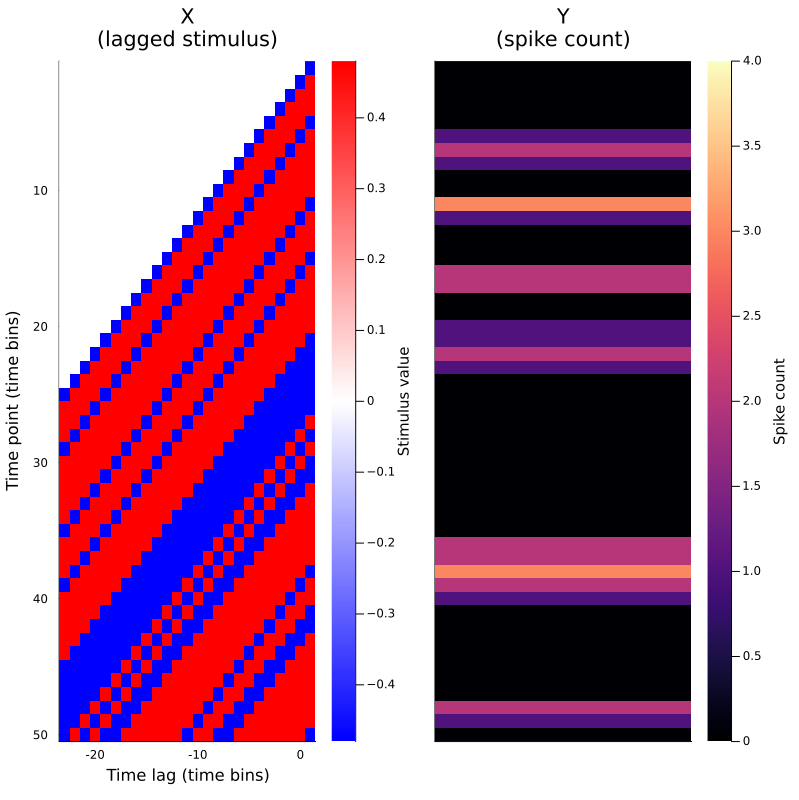

In [8]:
function make_design_matrix(stim; d=25)
    """
    Create time-lag design matrix from stimulus intensity vector.

    Args:
        stim (Vector): Stimulus intensity at each time point.
        d (Number): Number of time lags to use.

    Returns:
        X (Matrix): GLM design matrix with shape T, d
    """

    # Create version of stimulus vector with zeros before onset
    padded_stim = vcat(zeros(d - 1), stim)

    # Construct a matrix where each row has the d frames of
    # the stimulus preceding and including timepoint t
    T = length(stim)  # Total number of timepoints (hint: number of stimulus frames)
    X = zeros(T, d)
    for t in 1:T
        X[t, :] = padded_stim[t:t+d-1]
    end

    return X
end

# Make design matrix
X = make_design_matrix(stim)

# Visualize
plot_glm_matrices(X, spikes)

## Section 1.2: Fit Linear-Gaussian regression model

*Estimated timing to here from start of tutorial: 25 min*


First, we will use the design matrix to compute the maximum likelihood estimate for a linear-Gaussian GLM (aka "general linear model"). The maximum likelihood estimate of $\theta$ in this model can be solved analytically using the equation you learned about on Day 3:

\begin{equation}
\boldsymbol{\hat \theta} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{y}
\end{equation}

Before we can apply this equation, we need to augment the design matrix to account for the mean of $y$, because the spike counts are all $\geq 0$. We do this by adding a constant column of 1's to the design matrix, which will allow the model to learn an additive offset weight. We will refer to this additional weight as $b$ (for bias), although it is alternatively known as a "DC term" or "intercept".

In [9]:
# Build the full design matrix
y = spikes
constant = ones(length(y))
X = hcat(constant, make_design_matrix(stim))

# Get the MLE weights for the LG model
theta = inv(X' * X) * X' * y
theta_lg = theta[2:end]
print(theta_lg)

[-0.01300690042332453, 0.00034156930170707605, 0.006738227699109401, 0.007236943270919159, -0.0006298059025350469, 0.001771928305184515, -0.00533178171704727, -0.031771342256447364, -0.04352427439099966, -0.06521481504949894, -0.08710334653536972, -0.08816002314025895, -0.1399155626067734, -0.15142539808009672, -0.1654892630394884, -0.15509641488579035, -0.17627362411649636, -0.21251581685578658, -0.13940580668600136, 0.30337820044253505, 0.5755605709186989, 0.4405971920060464, 0.13711883201944197, 0.016048996752696457, -0.0016680551856500725]

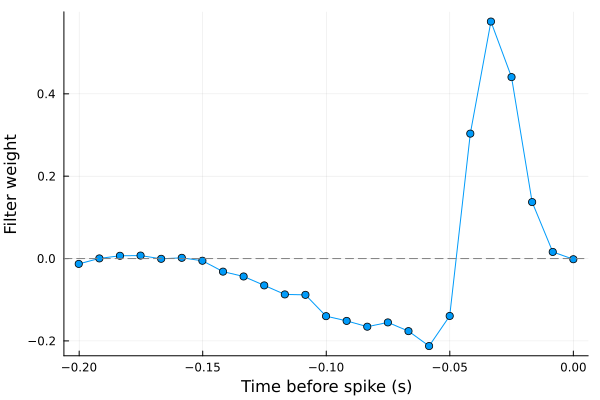

In [10]:
plot_spike_filter(theta_lg, dt_stim)

### Coding Exercise 1.2: Predict spike counts with Linear-Gaussian model

Now we are going to put these pieces together and write a function that outputs a predicted spike count for each timepoint using the stimulus information.

Your steps should be:

- Create the complete design matrix
- Obtain the MLE weights ($\boldsymbol{\hat \theta}$)
- Compute $\mathbf{\hat y} = \mathbf{X}\boldsymbol{\hat \theta}$

In [11]:
function predict_spike_counts_lg(stim::Vector{T}, spikes::Vector{T}, d::Int=25) where T <: Real
    #=
    Compute a vector of predicted spike counts given the stimulus.
    Args:
    stim: Stimulus values at each timepoint
    spikes: Spike counts measured at each timepoint
    d: Number of time lags to use.
    Returns:
    yhat: Predicted spikes at each timepoint.
    =#

    # Create the design matrix
    y = spikes
    constant = ones(length(y))
    X = hcat(constant, make_design_matrix(stim))
    # Get the MLE weights for the LG model
    theta = inv(X' * X) * X' * y
    
    # Compute predicted spike counts
    yhat = X * theta
    
    return yhat
end

predict_spike_counts_lg (generic function with 2 methods)

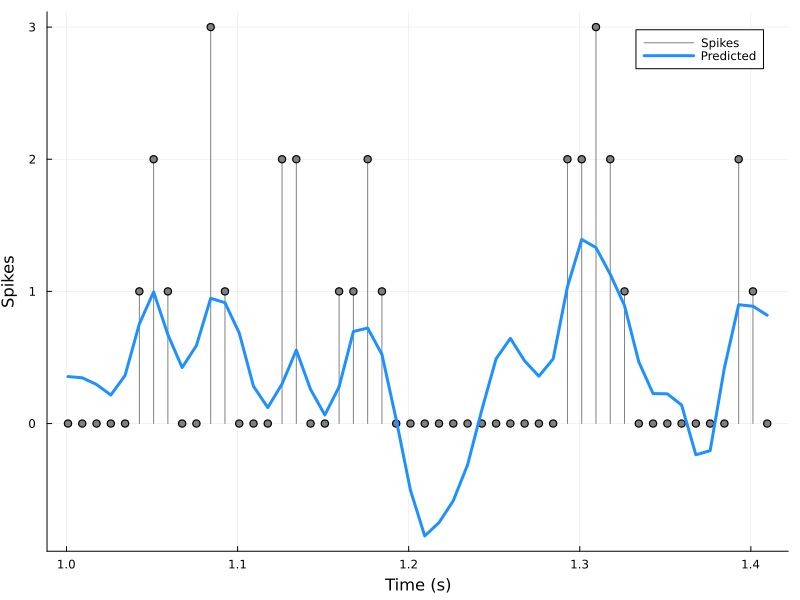

In [12]:
# Usage:
# Predict spike counts
predicted_counts = predict_spike_counts_lg(stim, spikes)

# Visualize
plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)

Is this a good model? The prediction line more-or-less follows the bumps in the spikes, but it never predicts as many spikes as are actually observed. And, more troublingly, it's predicting *negative* spikes for some time points.

The Poisson GLM will help to address these failures.


### Bonus challenge

The "spike-triggered average" falls out as a subcase of the linear Gaussian GLM: $\mathrm{STA} = \mathbf{X}^{\top} \mathbf{y} \,/\, \textrm{sum}(\mathbf{y})$, where $\mathbf{y}$ is the vector of spike counts of the neuron. In the LG GLM, the term $(\mathbf{X}^{\top}\mathbf{X})^{-1}$ corrects for potential correlation between the regressors. Because the experiment that produced these data used a white noise stimulus, there are no such correlations. Therefore the two methods are equivalent. (How would you check the statement about no correlations?)

---
# Section 2: Linear-Nonlinear-Poisson GLM

*Estimated timing to here from start of tutorial: 36 min*

Video available at https://youtube.com/watch?v=wRbvwdze4uE

## Section 2.1: Nonlinear optimization with `RxInfer`

*Estimated timing to here from start of tutorial: 45 min*

Before diving into the Poisson GLM case, let us review the use and importance of convexity in optimization:
- We have seen previously that in the Linear-Gaussian case, maximum likelihood  parameter estimate can be computed analytically. That is great because it only takes us a single line of code!
- Unfortunately in general there is no analytical solution to our statistical estimation problems of interest. Instead, we need to apply a nonlinear optimization algorithm to find the parameter values that minimize some *objective function*. This can be extremely tedious because there is no general way to check whether we have found *the optimal solution* or if we are just stuck in some local minimum.
- Somewhere in between these two extremes, the special case of convex objective function is of great practical importance. Indeed, such optimization problems can be solved very reliably (and usually quite rapidly too!) using some standard software.

Notes:
- a function is convex if and only if its curve lies below any chord joining two of its points
- to learn more about optimization, you can consult the book of Stephen Boyd and Lieven Vandenberghe [Convex Optimization](https://web.stanford.edu/~boyd/cvxbook/).

### Coding Exercise 2.1: Fitting the Poisson GLM and prediction spikes

**TODO**: Update this to describe RxInfer's method of optimization

In this exercise, we will use [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to compute maximum likelihood estimates for the filter weights in the Poisson GLM model with an exponential nonlinearity (LNP: Linear-Nonlinear-Poisson).

In practice, this will involve filling out two functions.

- The first should be an *objective function* that takes a design matrix, a spike count vector, and a vector of parameters. It should return a negative log likelihood.
- The second function should take `stim` and `spikes`, build the design matrix and then use `minimize` internally, and return the MLE parameters.

What should the objective function look like? We want it to return the negative log likelihood: $-\log P(y \mid \mathbf{X}, \theta).$

In the Poisson GLM, 

\begin{equation}
\log P(\mathbf{y} \mid \mathbf{X}, \theta) = \sum_t \log P(y_t \mid \mathbf{x_t},\theta),
\end{equation}

where

\begin{equation}
P(y_t \mid \mathbf{x_t}, \theta) = \frac{\lambda_t^{y_t}\exp(-\lambda_t)}{y_t!} \text{, with rate } \lambda_t = \exp(\mathbf{x_t}^{\top} \theta).
\end{equation}

Now, taking the log likelihood for all the data we obtain:

\begin{equation}
\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log\left(\lambda_t) - \lambda_t - \log(y_t !)\right).
\end{equation}

Because we are going to minimize the negative log likelihood with respect to the parameters $\theta$, we can ignore the last term that does not depend on $\theta$. For faster implementation, let us rewrite this in matrix notation:

\begin{equation}
\mathbf{y}^{\top} \log(\mathbf{\lambda}) - \mathbf{1}^{\top} \mathbf{\lambda} \text{, with  rate } \mathbf{\lambda} = \exp(\mathbf{X} \theta)
\end{equation}

Finally, don't forget to add the minus sign for your function to return the negative log likelihood.

In [13]:
struct NonLinearNode end # Dummy structure just to make Julia happy

struct NonlinearMeta{R, F}
    rng      :: R
    fn       :: F   # Nonlinear function, we assume 1 float input - 1 float output
    nsamples :: Int # Number of samples used in approximation
end

In [14]:
@node NonLinearNode Deterministic [ out, in ]

In [15]:
# Rule for outbound message on `out` edge given inbound message on `in` edge
@rule NonLinearNode(:out, Marginalisation) (m_in::NormalMeanVariance, meta::NonlinearMeta) = begin 
    samples = rand(meta.rng, m_in, meta.nsamples)
    return SampleList(map(meta.fn, samples))
end

In [16]:
# Rule for outbound message on `in` edge given inbound message on `out` edge
@rule NonLinearNode(:in, Marginalisation) (m_out::Gamma, meta::NonlinearMeta) = begin     
    return ContinuousUnivariateLogPdf((x) -> logpdf(m_out, meta.fn(x)))
end

In [23]:
@model function poisson_glm(X, y)
    θ ~ Normal(mean = 0.0, variance = 1.0)
    λ ~ NonLinearNode(X .* θ)
    for i in eachindex(y)
        y[i] ~ Poisson(λ)
    end
end

In [24]:
nonlinear_fn(x) = exp(x)

nonlinear_fn (generic function with 1 method)

In [25]:
@constraints function nconstsraints(nsamples)
    q(θ) :: SampleListFormConstraint(nsamples, LeftProposal())
    q(λ) :: SampleListFormConstraint(nsamples, RightProposal())
    
    q(θ, λ) = q(θ)q(λ)
end

nconstsraints (generic function with 1 method)

In [26]:
@meta function nmeta(fn, nsamples)
    NonLinearNode(θ, λ) -> NonlinearMeta(StableRNG(123), fn, nsamples)
end

nmeta (generic function with 1 method)

In [29]:
@initialization function ninit()
    q(λ) = vague(Gamma)
end

ninit (generic function with 1 method)

In [30]:
function fit_lnp(stim, spikes, d=25)

    # Build the design matrix/home/john/reactiveBayes/examples/juliaTutorials
    constant = ones(length(spikes))
    X = hcat(constant, make_design_matrix(stim))
    nsamples = 10

    # Run variational inference
    results = infer(
        model = poisson_glm(),
        meta =  nmeta(nonlinear_fn, nsamples),
        constraints = nconstsraints(nsamples),
        data = (y = spikes, X = X),
        initialization = ninit(),
        iterations = 1,  
        returnvars = (θ = KeepLast(), ),
        free_energy = true
    )

    # Extract the posterior mean of θ
    θ_post = results.posterior[:θ]

    return θ_post
end

# Fit LNP model
theta_lnp = fit_lnp(stim, spikes)

# plot_spike_filter(theta_lnp, dt_stim)

OutOfMemoryError: OutOfMemoryError()